In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os, cv2, re, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from google.colab.patches import cv2_imshow


Mounted at /content/drive


In [ ]:
DATA_ROOT = "/content/drive/MyDrive/TuSimple/tusimple_preprocessed/training"

IMG_DIR  = os.path.join(DATA_ROOT, "frames")
MASK_DIR = os.path.join(DATA_ROOT, "lane-masks")

print("Images dir:", IMG_DIR)
print("Masks dir :", MASK_DIR)
print("Example images:", os.listdir(IMG_DIR)[:5])
print("Example masks :", os.listdir(MASK_DIR)[:5])



Images dir: /content/drive/MyDrive/TuSimple/tusimple_preprocessed/training/frames
Masks dir : /content/drive/MyDrive/TuSimple/tusimple_preprocessed/training/lane-masks
Example images: ['0313-2_61620.jpg', '0313-2_42820.jpg', '0313-2_55.jpg', '0313-2_60960.jpg', '0313-2_58920.jpg']
Example masks : ['0313-2_39700.jpg', '0313-2_62580.jpg', '0313-2_36920.jpg', '0313-2_42520.jpg', '0313-2_40020.jpg']


In [ ]:
class TuSimplePreprocessedDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(256, 512)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_size = img_size

        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        # all image files
        img_files = sorted([f for f in os.listdir(img_dir)
                            if f.lower().endswith((".png", ".jpg", ".jpeg"))])

        mask_files_set = set([f for f in os.listdir(mask_dir)
                              if f.lower().endswith((".png", ".jpg", ".jpeg"))])

        self.pairs = []
        for f in img_files:
            if f in mask_files_set:
                self.pairs.append((f, f))   # same name
        print(f"Loaded {len(self.pairs)} image–mask pairs.")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_name, mask_name = self.pairs[idx]

        img_path  = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # read
        img  = cv2.imread(img_path)
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # resize
        img  = cv2.resize(img, self.img_size[::-1])   # (w,h)
        mask = cv2.resize(mask, self.img_size[::-1], interpolation=cv2.INTER_NEAREST)

        # binary mask
        mask = (mask > 128).astype(np.float32)

        img_t  = self.normalize(self.to_tensor(img))
        mask_t = torch.tensor(mask).unsqueeze(0)

        return img_t, mask_t


In [ ]:
train_ds = TuSimplePreprocessedDataset(IMG_DIR, MASK_DIR, img_size=(256, 512))
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

print("Dataset size:", len(train_ds))

# one batch to verify shapes
img_batch, mask_batch = next(iter(train_loader))
print("Image batch:", img_batch.shape)  # [B, 3, 256, 512]
print("Mask batch :", mask_batch.shape) # [B, 1, 256, 512]


Loaded 3626 image–mask pairs.
Dataset size: 3626
Image batch: torch.Size([4, 3, 256, 512])
Mask batch : torch.Size([4, 1, 256, 512])


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(3, 64);   self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(64, 128); self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(128, 256);self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(256, 512);self.p4 = nn.MaxPool2d(2)

        self.b  = DoubleConv(512, 1024)

        self.u4 = nn.ConvTranspose2d(1024, 512, 2, 2); self.c4 = DoubleConv(1024, 512)
        self.u3 = nn.ConvTranspose2d(512, 256, 2, 2);  self.c3 = DoubleConv(512, 256)
        self.u2 = nn.ConvTranspose2d(256, 128, 2, 2);  self.c2 = DoubleConv(256, 128)
        self.u1 = nn.ConvTranspose2d(128, 64, 2, 2);   self.c1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.d1(x); p1 = self.p1(c1)
        c2 = self.d2(p1); p2 = self.p2(c2)
        c3 = self.d3(p2); p3 = self.p3(c3)
        c4 = self.d4(p3); p4 = self.p4(c4)

        b  = self.b(p4)

        u4 = self.u4(b); u4 = torch.cat([u4, c4], dim=1); c5 = self.c4(u4)
        u3 = self.u3(c5); u3 = torch.cat([u3, c3], dim=1); c6 = self.c3(u3)
        u2 = self.u2(c6); u2 = torch.cat([u2, c2], dim=1); c7 = self.c2(u2)
        u1 = self.u1(c7); u1 = torch.cat([u1, c1], dim=1); c8 = self.c1(u1)

        return self.final(c8)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 8

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for batch_idx, (img, mask) in enumerate(train_loader):
        img, mask = img.to(device), mask.to(device)

        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 20 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} total loss: {total_loss:.4f}")


Device: cuda

Epoch 1/8
  Batch 0/907 - Loss: 0.6119
  Batch 20/907 - Loss: 0.4173
  Batch 40/907 - Loss: 0.3391
  Batch 60/907 - Loss: 0.3057
  Batch 80/907 - Loss: 0.2973
  Batch 100/907 - Loss: 0.2781
  Batch 120/907 - Loss: 0.2666
  Batch 140/907 - Loss: 0.2597
  Batch 160/907 - Loss: 0.2403
  Batch 180/907 - Loss: 0.2322
  Batch 200/907 - Loss: 0.2369
  Batch 220/907 - Loss: 0.2292
  Batch 240/907 - Loss: 0.2075
  Batch 260/907 - Loss: 0.2018
  Batch 280/907 - Loss: 0.2054
  Batch 300/907 - Loss: 0.1949
  Batch 320/907 - Loss: 0.1806
  Batch 340/907 - Loss: 0.1831
  Batch 360/907 - Loss: 0.1958
  Batch 380/907 - Loss: 0.1695
  Batch 400/907 - Loss: 0.1642
  Batch 420/907 - Loss: 0.1565
  Batch 440/907 - Loss: 0.1529
  Batch 460/907 - Loss: 0.1531
  Batch 480/907 - Loss: 0.1492
  Batch 500/907 - Loss: 0.1374
  Batch 520/907 - Loss: 0.1470
  Batch 540/907 - Loss: 0.1373
  Batch 560/907 - Loss: 0.1355
  Batch 580/907 - Loss: 0.1222
  Batch 600/907 - Loss: 0.1262
  Batch 620/907 - Los

In [ ]:
def predict_mask(img_bgr):
    """img_bgr: OpenCV image"""
    h, w = img_bgr.shape[:2]

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img_rgb, (512, 256))  # (w,h)

    t = T.ToTensor()(resized)
    t = T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])(t)
    t = t.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = torch.sigmoid(model(t))[0,0].cpu().numpy()

    pred = cv2.resize(pred, (w, h))
    mask = (pred > 0.5).astype(np.uint8)
    return mask

def overlay_lane(img_bgr, mask):
    out = img_bgr.copy()
    out[mask == 1] = (0, 255, 0)  # green lanes
    return cv2.addWeighted(out, 0.6, img_bgr, 0.4, 0)


Test image: 0313-1_31380.jpg


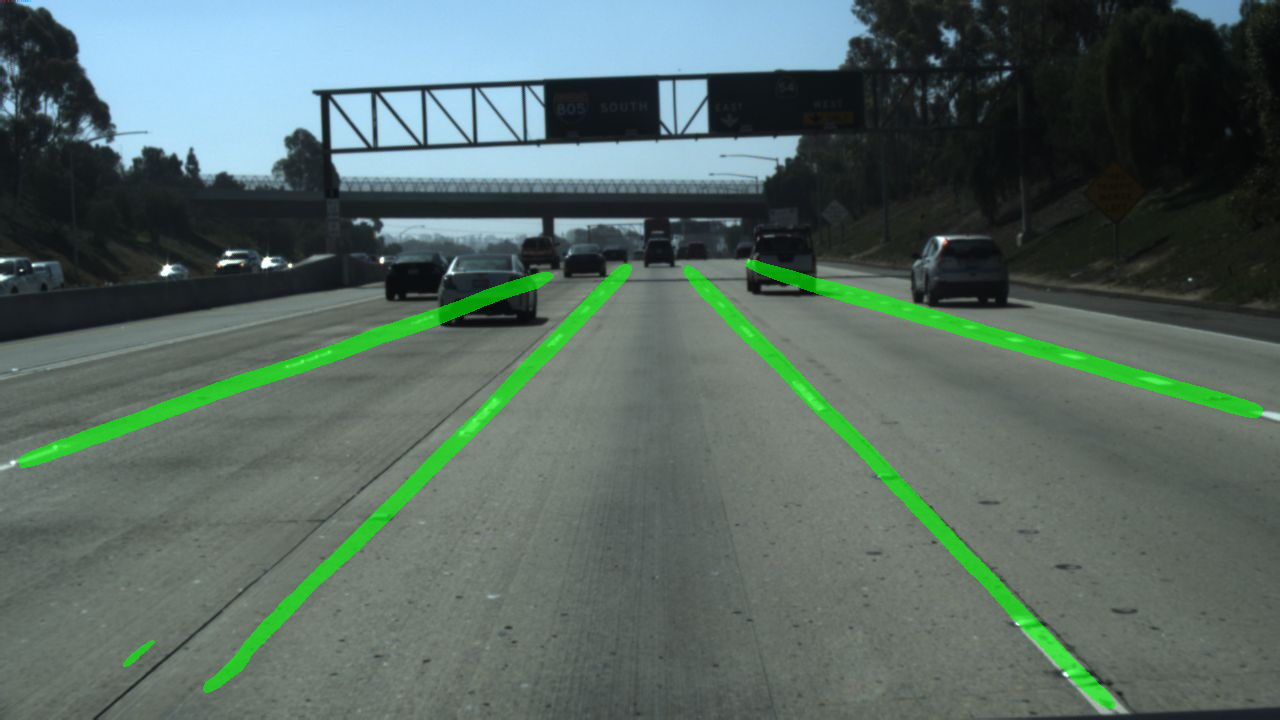

In [ ]:
import random
import cv2
from google.colab.patches import cv2_imshow

# randomly select another image
random_img = random.choice(os.listdir(IMG_DIR))
test_path = os.path.join(IMG_DIR, random_img)

# load image
img = cv2.imread(test_path)

# run model prediction
mask = predict_mask(img)

# apply overlay
result = overlay_lane(img, mask)

print("Test image:", random_img)
cv2_imshow(result)


In [ ]:
from torch.utils.data import random_split

val_size = int(0.2 * len(train_ds))
train_size = len(train_ds) - val_size

train_dataset, val_dataset = random_split(train_ds, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))


Train size: 2901
Val size: 725


In [ ]:
import torch
import numpy as np

def confusion_matrix(pred, target):
    pred = pred.view(-1)
    target = target.view(-1)

    tp = (pred * target).sum().item()
    tn = ((1-pred) * (1-target)).sum().item()
    fp = (pred * (1-target)).sum().item()
    fn = ((1-pred) * target).sum().item()

    return tp, fp, fn, tn


def dice_score(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return (2*inter + eps) / (pred.sum() + target.sum() + eps)


def iou_score(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter + eps) / (union + eps)


def pixel_accuracy(pred, target):
    correct = (pred == target).float().sum()
    return (correct / target.numel()).item()


def precision(pred, target, eps=1e-6):
    tp = (pred * target).sum()
    fp = (pred * (1-target)).sum()
    return float((tp + eps) / (tp + fp + eps))


def recall(pred, target, eps=1e-6):
    tp = (pred * target).sum()
    fn = ((1-pred) * target).sum()
    return float((tp + eps) / (tp + fn + eps))


def specificity(pred, target, eps=1e-6):
    tn = ((1-pred) * (1-target)).sum()
    fp = (pred * (1-target)).sum()
    return float((tn + eps) / (tn + fp + eps))


In [ ]:
model.eval()

dice_scores = []
iou_scores = []
acc_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

TP = FP = FN = TN = 0

with torch.no_grad():
    for img, mask in val_loader:
        img = img.to(device)
        mask = mask.to(device)

        pred = torch.sigmoid(model(img))
        pred = (pred > 0.5).float()

        for p, m in zip(pred, mask):
            # confusion matrix
            tp, fp, fn, tn = confusion_matrix(p, m)
            TP += tp
            FP += fp
            FN += fn
            TN += tn

            dice_scores.append(dice_score(p, m).item())
            iou_scores.append(iou_score(p, m).item())
            acc_scores.append(pixel_accuracy(p, m))
            precision_scores.append(precision(p, m))
            recall_scores.append(recall(p, m))
            specificity_scores.append(specificity(p, m))


In [ ]:
print("========== METRICS SUMMARY ==========")
print(f"Dice Score     : {np.mean(dice_scores):.4f}")
print(f"IoU Score      : {np.mean(iou_scores):.4f}")
print(f"Accuracy       : {np.mean(acc_scores):.4f}")
print(f"Precision      : {np.mean(precision_scores):.4f}")
print(f"Recall         : {np.mean(recall_scores):.4f}")
print(f"Specificity    : {np.mean(specificity_scores):.4f}")

print("\n========== CONFUSION MATRIX ==========")
print(f"TP: {TP}  FP: {FP}  FN: {FN}  TN: {TN}")


========== METRICS SUMMARY ==========
Dice Score     : 0.8051
IoU Score      : 0.6782
Accuracy       : 0.9843
Precision      : 0.8488
Recall         : 0.7682
Specificity    : 0.9940

========== CONFUSION MATRIX ==========
TP: 3089353.0  FP: 550107.0  FN: 941927.0  TN: 90445813.0


In [ ]:
model = UNet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/TuSimple/unet_lane_model.pth"))
model.eval()
print("Model loaded!")


Model loaded!


Test image: 0313-2_10860.jpg


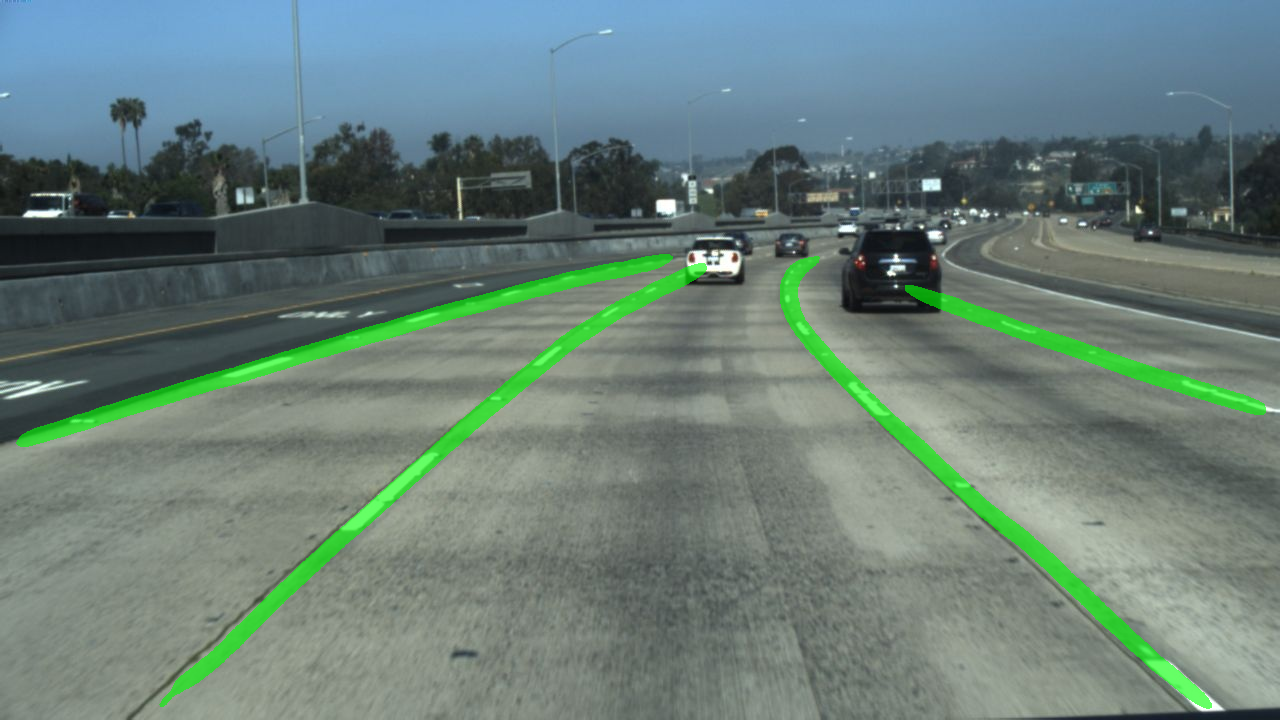

In [ ]:
frames_dir = "/content/drive/MyDrive/TuSimple/tusimple_preprocessed/training/frames"
test_name = os.listdir(frames_dir)[0]
test_path = os.path.join(frames_dir, test_name)

test = cv2.imread(test_path)
mask = predict_mask(test)
result = overlay_lane(test, mask)

print("Test image:", test_name)
cv2_imshow(result)



In [ ]:
save_path = "/content/drive/MyDrive/TuSimple/unet_lane_weights.pth"
torch.save(model.state_dict(), save_path)
print("Weights saved at:", save_path)


Weights saved at: /content/drive/MyDrive/TuSimple/unet_lane_weights.pth


In [ ]:
model = UNet().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/TuSimple/unet_lane_weights.pth"))
model.eval()

print("Weights loaded!")


Weights loaded!
